Below is the following code from the `valence_build` and `valence_analyze` notebooks. After executing this code this notebook will demonstrate some methods for plotting and reporting the data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from valence.build import AgilentGcms
from valence.analyze import match_area, std_curves, concentrations

%matplotlib inline

In [2]:
agi = AgilentGcms.from_root('data')

In [3]:
lib = agi.results_lib
area = agi.results_tic
stnd = pd.read_csv('data\standards.csv')

In [4]:
comp = match_area(lib,area)
curves = std_curves(comp,stnd)
conc = concentrations(comp,curves)

## Plotting Chromatograms
First get the chromatogram data from valence

In [11]:
chroms = agi.chromatogram

Below is an example function using `matlibplot` which plots all of the chromatograms in one figure. The function can be customized to do more. We are working on a package to include this functionality.

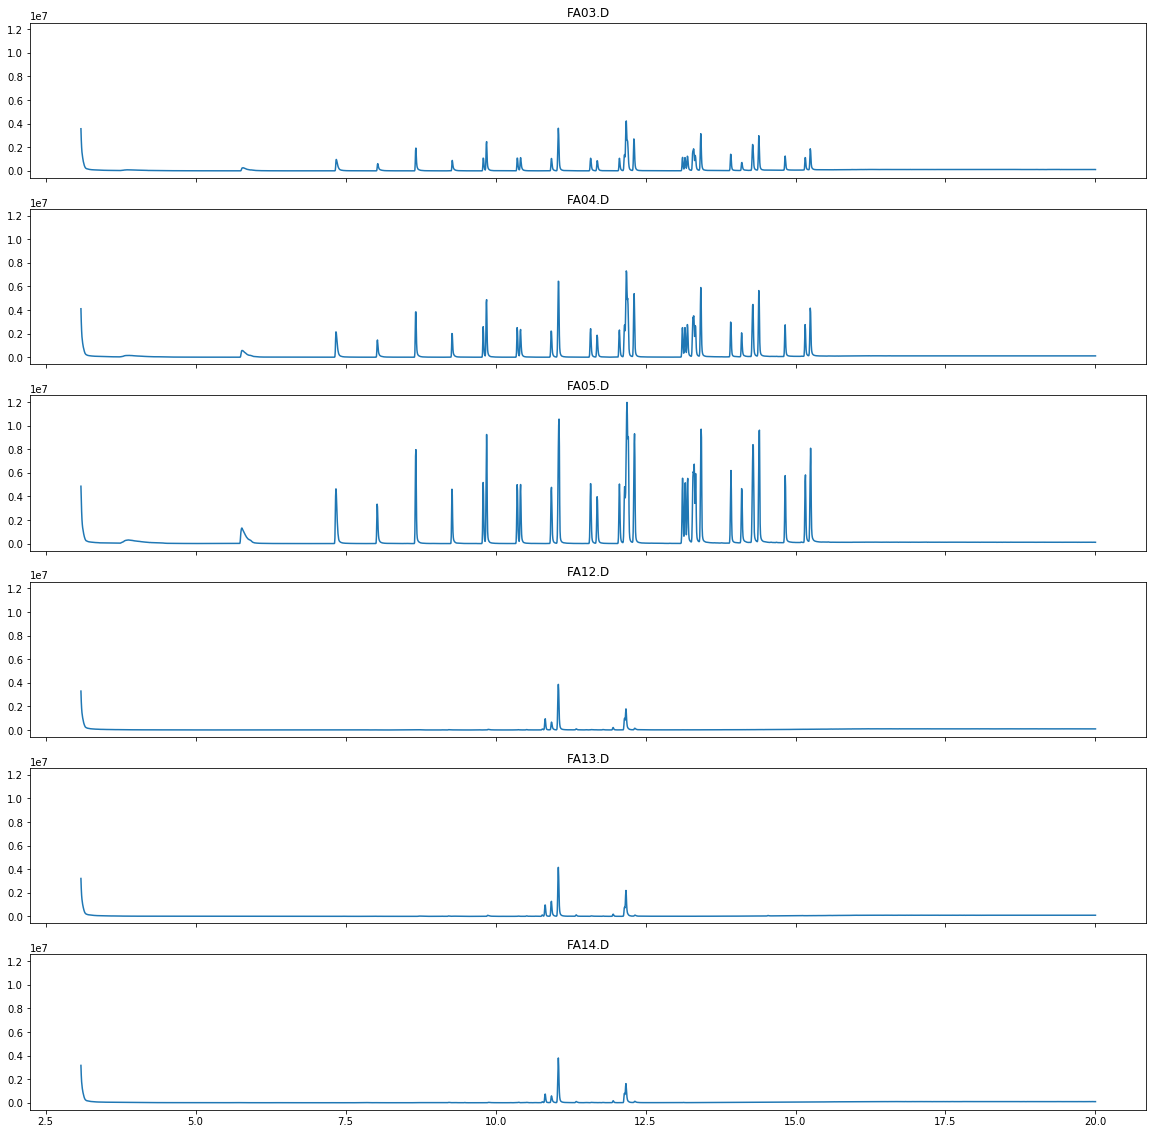

In [17]:
def plot_chroms(chroms):
    fig_name= sorted(list(set(chrom.index)))
    f, (figs) = plt.subplots(len(fig_name),sharex=True,sharey=True)
    for i in range(len(fig_name)):
        figs[i].plot(chrom.loc[fig_name[i]].tme,chrom.loc[fig_name[i]].tic)
        figs[i].set_title(fig_name[i])
    #     figs[i].set_xlim(xlimits)
    #     figs[i].set_ylim(ylimits)

    f.set_figheight(20)
    f.set_figwidth(20)
plot_chroms(chroms)

Save the file to a pdf to view or put in reports.

In [19]:
f.savefig("chromatograms.pdf", bbox_inches='tight')

## Building Pivot Tables

## Bar Plots

## Report Results
### Pivot Table 
Pivot tables are generally a nice way of organizing printing data. The `.pivot` method is relatively simple to implement on your own. If there are other cases which could be useful below is an example of creating our own pivot table with pandas `.pivot_table` method.

*Note: it is important to reset the index of the gcq.concentrations dataframe so the `key` is then a column and not the index.*

In [ ]:
pd.pivot_table(gcq.concentrations.reset_index(),
               index='library_id',
               columns='key',
               values='conc').head()

In [ ]:
pd.pivot_table(gcq.concentrations_exp.reset_index(),
               index='library_id',
               columns='key',
               values='conc').head()

In [ ]:
pd.pivot_table(gcq.concentrations_std.reset_index(),
               index='library_id',
               columns='key',
               values='conc').head()

We can also just look at our experimental data without the standard curve data by simply calling `gcq.concentrations_exp`. Similarly, we can get just the standard curve data `gcq.concentrations_std` and place either in a pivot table.

Your data can easily be plotted with GCQuant. There are many plotting packages available in python, but here Bokeh is used to prepare a few simple examples which you can use as a quick check or to build upon.

Bokeh has very good documentation so detailed explanation of the code can be understood by referencing Bokeh's documentation.

First import the required classes

In [ ]:
from bokeh.charts import Bar, show, output_notebook
from bokeh.layouts import row

To see the charts displayed in the notebook use the line below.

In [ ]:
output_notebook()

Now a bar chart of the concentration percents can be created

In [ ]:
bar_conc_per = Bar(gcq.concentrations_exp.reset_index(),
                       label ='key',
                       values = 'conc%',
                       agg='sum',
                       stack='library_id',
                       title = 'Concentration Percentage')
show(bar_conc_per)

To plot absolute values we can create a similiar plot.

In [ ]:
bar_conc_abs = Bar(gcq.concentrations_exp.reset_index(),
                       label ='key',
                       values = 'conc',
                       agg='sum',
                       stack='library_id',
                       title = 'Concentration')
show(bar_conc_abs)

The same data but not stacked.

In [ ]:
bar_conc_abs_nostack = Bar(gcq.concentrations_exp.reset_index(),
                       label ='key',
                       values = 'conc',
                       group = 'library_id',
                       title = 'Concentration')
show(bar_conc_abs_nostack)

Combining plots

In [ ]:
show(row(bar_conc_per,bar_conc_abs_nostack)) 